#**유통 판매량 예측 및 재고 최적화**
## **단계1 : 데이터 탐색 및 가설 도출**

# **0.미션**

* 예측해야 할 핵심상품 역할 분담
    * 핵심상품 별로, 데이터 탐색, 가설수립, 데이터셋 구성
    * 1인당 1~2개 정도를 분담하여 개별 과제 수행
    * 팀 미팅을 통해 진행 사항 공유 및 취합

* 데이터 탐색 및 가설 도출
    * 주어진 데이터에 대해 대상 매장, 대상 상품의 그래프 그리고 시계열 패턴을 찾기
    * 찾은 패턴을 기반으로 가설 도출

* 대상 상품(핵심 상품)

| Product_ID|Product_Code|SubCategory|Category|LeadTime|Price|
|----|----|----|----|----|----|
|3|DB001|Beverage|Drink|2|8|
|12|GA001|Milk|Food|3|6|
|42|FM001|Agricultural products|Grocery|3|5|


# **1.환경설정**

* 세부 요구사항
    * 구글콜랩
        * 구글 드라이브 바로 밑에 project 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 라이브러리 로딩
        * 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### **(1) 경로 설정**

* 구글 드라이브 연결

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
path = '/content/drive/MyDrive/KT_aivle/DNN, RNN/Mini_project_6/'

### **(2) 라이브러리 설치 및 불러오기**

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.metrics import *
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

### **(3) 데이터 불러오기**

#### 1) 데이터로딩

In [17]:
oil_price = pd.read_csv(path + 'train/oil_price_train.csv')
orders = pd.read_csv(path + 'train/orders_train.csv')
sales = pd.read_csv(path + 'train/sales_train.csv')
products = pd.read_csv(path + 'train/products.csv')
stores = pd.read_csv(path + 'train/stores.csv')

sales['Date'] = pd.to_datetime(sales['Date'] )
oil_price['Date'] = pd.to_datetime(oil_price['Date'] )
orders['Date'] = pd.to_datetime(orders['Date'] )

#### 2) 기본 정보 조회

In [18]:
sales_of_44 = sales.loc[sales['Store_ID']==44]
sale_product = pd.merge(sales_of_44,products, on='Product_ID')
product_3 = sale_product.loc[sale_product['Product_ID']==3]#음료
product_12 = sale_product.loc[sale_product['Product_ID']==12]#우유
product_42 = sale_product.loc[sale_product['Product_ID']==42]#농산품
yogurt = sale_product.loc[sale_product['Product_ID']==8] # 요거트
bread = sale_product.loc[sale_product['Product_ID']==5] # 빵
egg = sale_product.loc[sale_product['Product_ID']==10] # 계란
meat = sale_product.loc[sale_product['Product_ID']==24] # 고기
frozen = sale_product.loc[sale_product['Product_ID']==11] # 냉동
sale_product

,Date,Store_ID,Qty,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price
0,2014-01-01,44,0.000,3,DB001,Beverage,Drink,2,8
1,2014-01-02,44,9853.000,3,DB001,Beverage,Drink,2,8
2,2014-01-03,44,8647.000,3,DB001,Beverage,Drink,2,8
3,2014-01-04,44,15153.000,3,DB001,Beverage,Drink,2,8
4,2014-01-05,44,15606.000,3,DB001,Beverage,Drink,2,8
...,...,...,...,...,...,...,...,...,...
18430,2017-02-24,44,153.499,32,GS001,Seafood,Grocery,3,34
18431,2017-02-25,44,115.110,32,GS001,Seafood,Grocery,3,34
18432,2017-02-26,44,108.920,32,GS001,Seafood,Grocery,3,34
18433,2017-02-27,44,119.734,32,GS001,Seafood,Grocery,3,34


In [19]:
oil_price['WTI_Price'].interpolate(method='linear', inplace=True, limit_direction='both')
oil_price

,Date,WTI_Price
0,2014-01-01,95.14
1,2014-01-02,95.14
2,2014-01-03,93.66
3,2014-01-06,93.12
4,2014-01-07,93.31
...,...,...
820,2017-02-22,53.61
821,2017-02-23,54.48
822,2017-02-24,53.99
823,2017-02-27,54.04


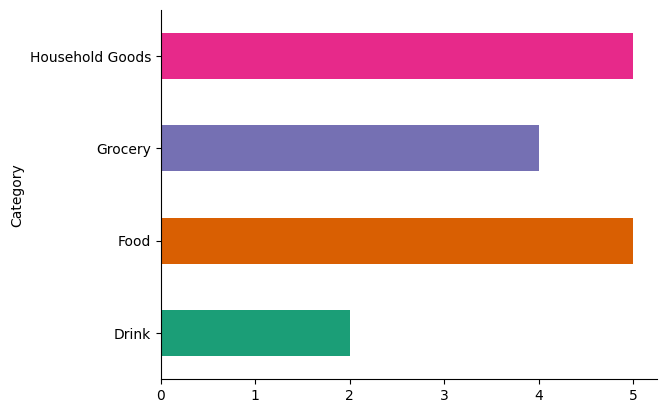

In [20]:
from matplotlib import pyplot as plt
import seaborn as sns
products.groupby('Category').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

# **2.데이터 탐색**

* 시계열 패턴을 찾아보기 위한 그래프를 그려 봅시다.

## **(1) 시계열 패턴 찾아보기1**

* 다음 항목은 패턴을 찾기 위한 예제 문항 입니다. 참조하여 시계열 패턴을 찾아 봅시다.
    * 대상 매장(44), 대상 상품(3,12,42)의 판매량 추이
    * 대상 상품의 동일 카테고리의 상품별 판매량 추이
    * 휘발류 가격과 상품 판매량 추이 비교
    * 방문 고객수와 상품 판매량 추이 비교
    * 그외...

### 1) 대상 매장(44), 대상 상품의 판매량 추이

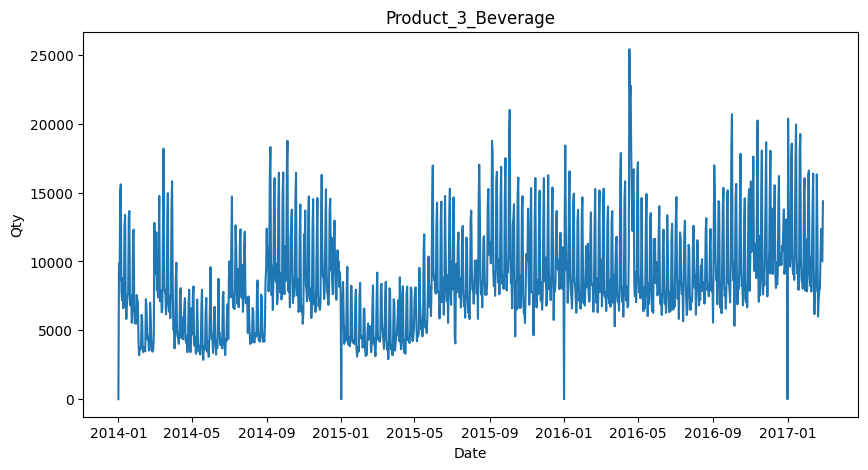

In [21]:
plt.figure(figsize=(10,5))
sns.lineplot(product_3, x='Date',y='Qty')
plt.title("Product_3_Beverage")
plt.show()

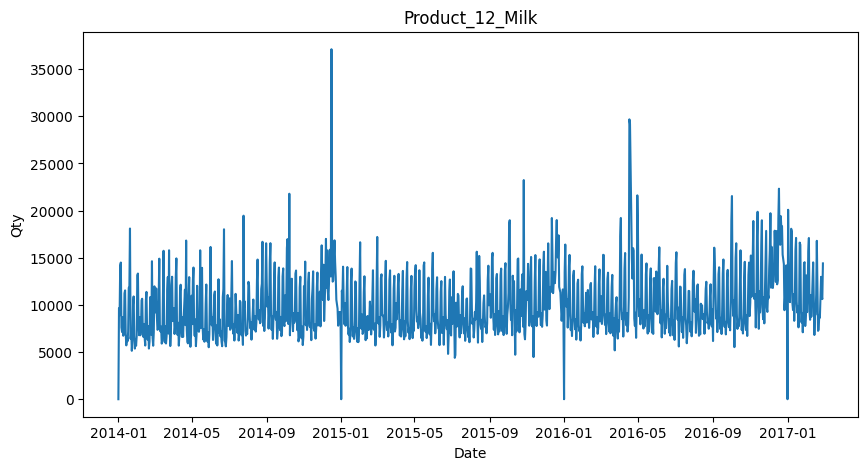

In [22]:
plt.figure(figsize=(10,5))
sns.lineplot(product_12, x='Date',y='Qty')
plt.title("Product_12_Milk")
plt.show()

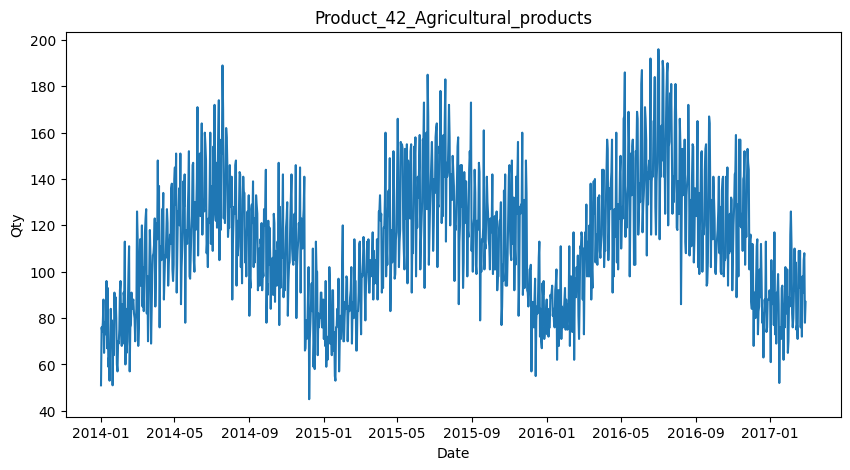

In [23]:
plt.figure(figsize=(10,5))
sns.lineplot(product_42, x='Date',y='Qty')
plt.title("Product_42_Agricultural_products")
plt.show()

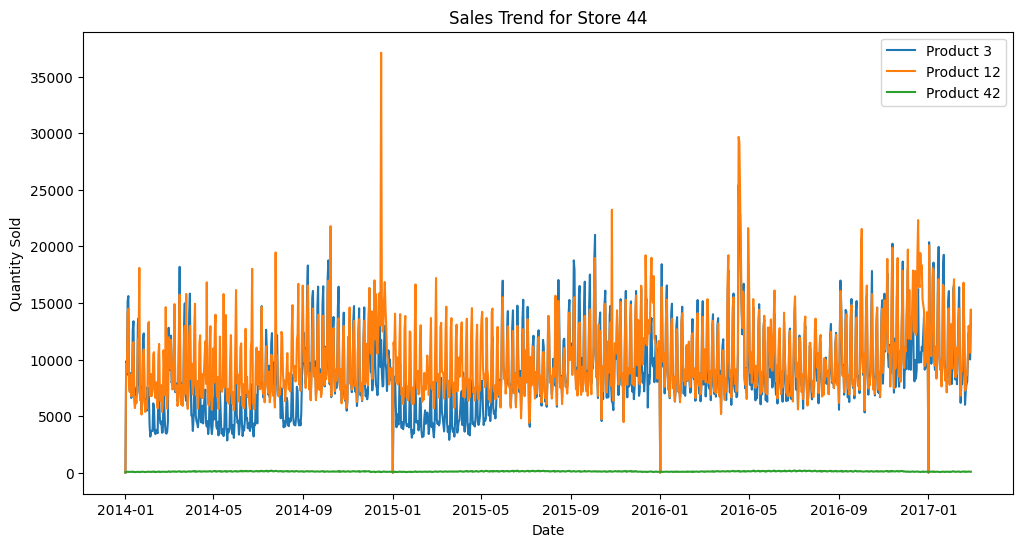

In [24]:
oil_price2 = oil_price.copy()
oil_price2['WTI_Price'].interpolate(method='linear', inplace=True, limit_direction='both')
merged_df = pd.merge(sales, oil_price2, on='Date', how='left')
merged_df = pd.merge(merged_df, orders, on=['Date', 'Store_ID'], how='left')
merged_df = pd.merge(merged_df, products, on='Product_ID', how='left')
merged_df = pd.merge(merged_df, stores, on='Store_ID', how='left')
target_store = 44
target_products = [3, 12, 42]

filtered_sales = merged_df[(merged_df['Store_ID'] == target_store) & (merged_df['Product_ID'].isin(target_products))]

plt.figure(figsize=(12, 6))
for product in target_products:
    product_sales = filtered_sales[filtered_sales['Product_ID'] == product]
    plt.plot(product_sales['Date'], product_sales['Qty'], label=f'Product {product}')

plt.title(f'Sales Trend for Store {target_store}')
plt.xlabel('Date')
plt.ylabel('Quantity Sold')
plt.legend()
plt.show()

### 2) 대상 상품의 동일 카테고리의 상품별 판매량 추이

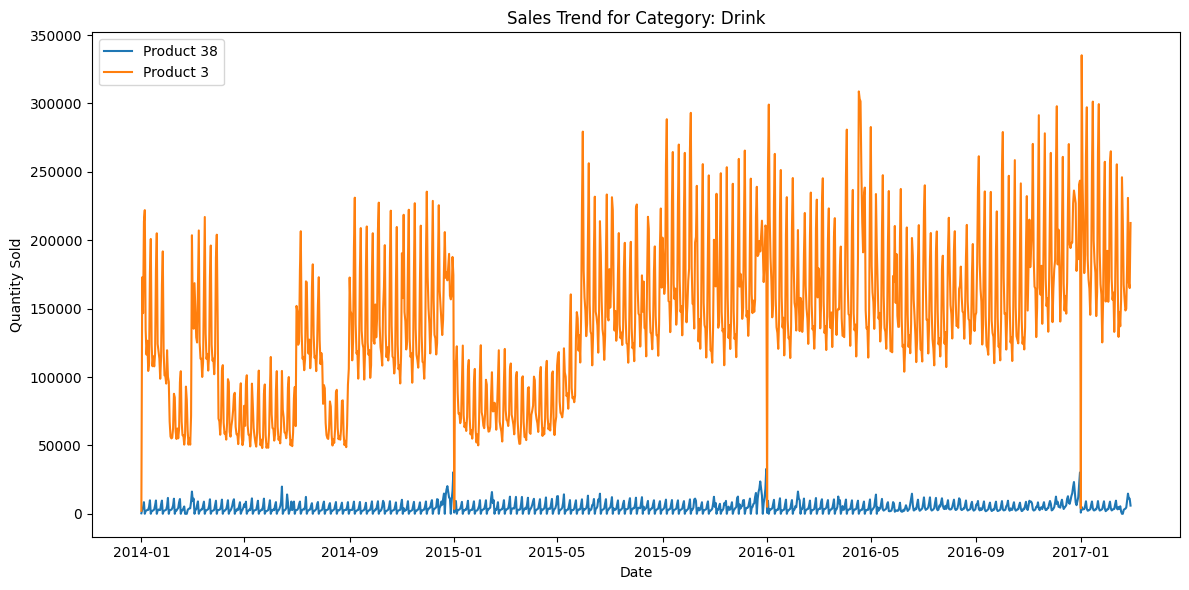

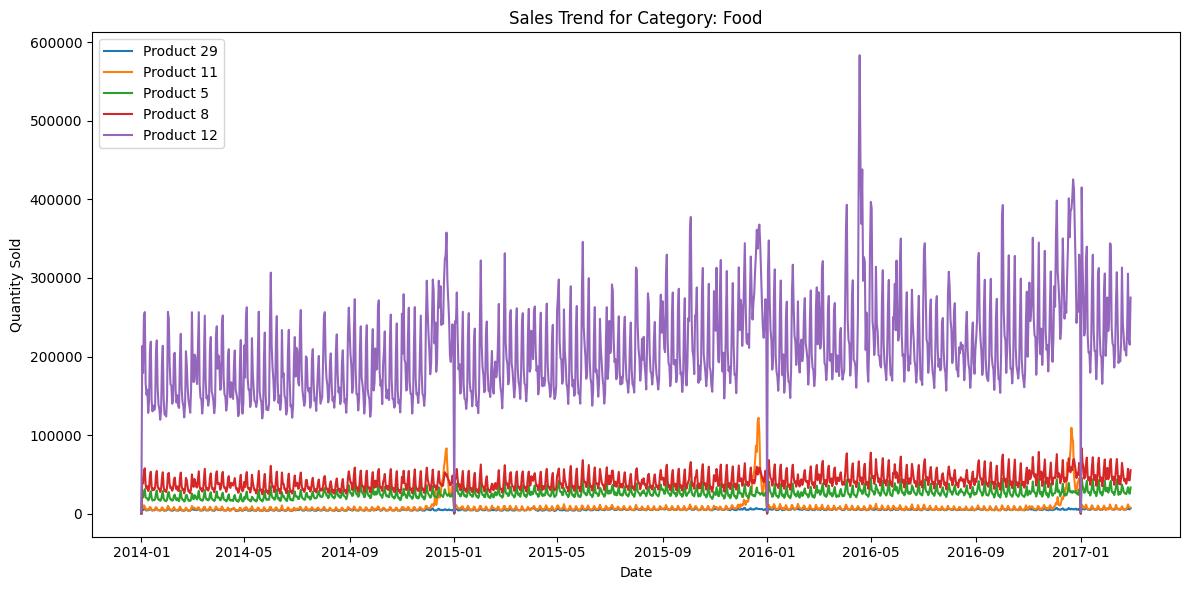

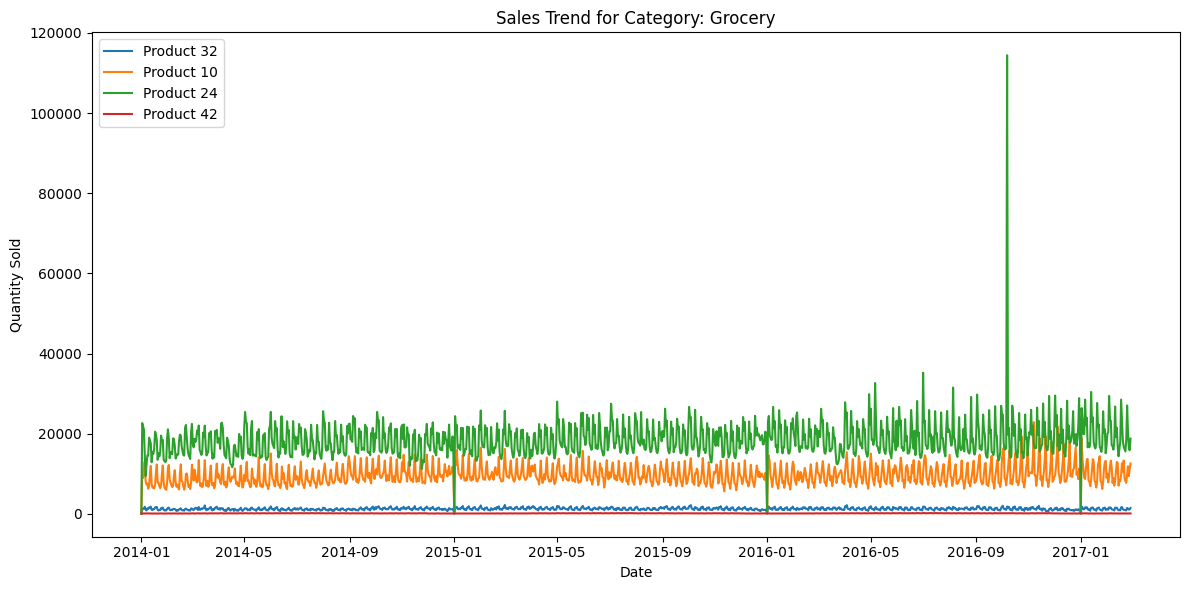

In [25]:
product_categories = products.set_index('Product_ID').loc[target_products, 'Category'].unique()
for idx, category in enumerate(product_categories, start=1):
    category_products = products[products['Category'] == category]['Product_ID']

    category_sales = merged_df[merged_df['Product_ID'].isin(category_products)]
    category_sales = category_sales.groupby(['Date', 'Product_ID'])['Qty'].sum().reset_index()

    plt.figure(figsize=(12, 6))

    for product in category_products:
        product_sales = category_sales[category_sales['Product_ID'] == product]
        plt.plot(product_sales['Date'], product_sales['Qty'], label=f'Product {product}')

    plt.title(f'Sales Trend for Category: {category}')
    plt.xlabel('Date')
    plt.ylabel('Quantity Sold')
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

12번 상품: 12번과 11번의 분포가 비슷한 것으로 보임. 단순 판매량은 12번이 압도적으로 많음

### 3) 휘발류 가격과 상품 판매량 추이 비교

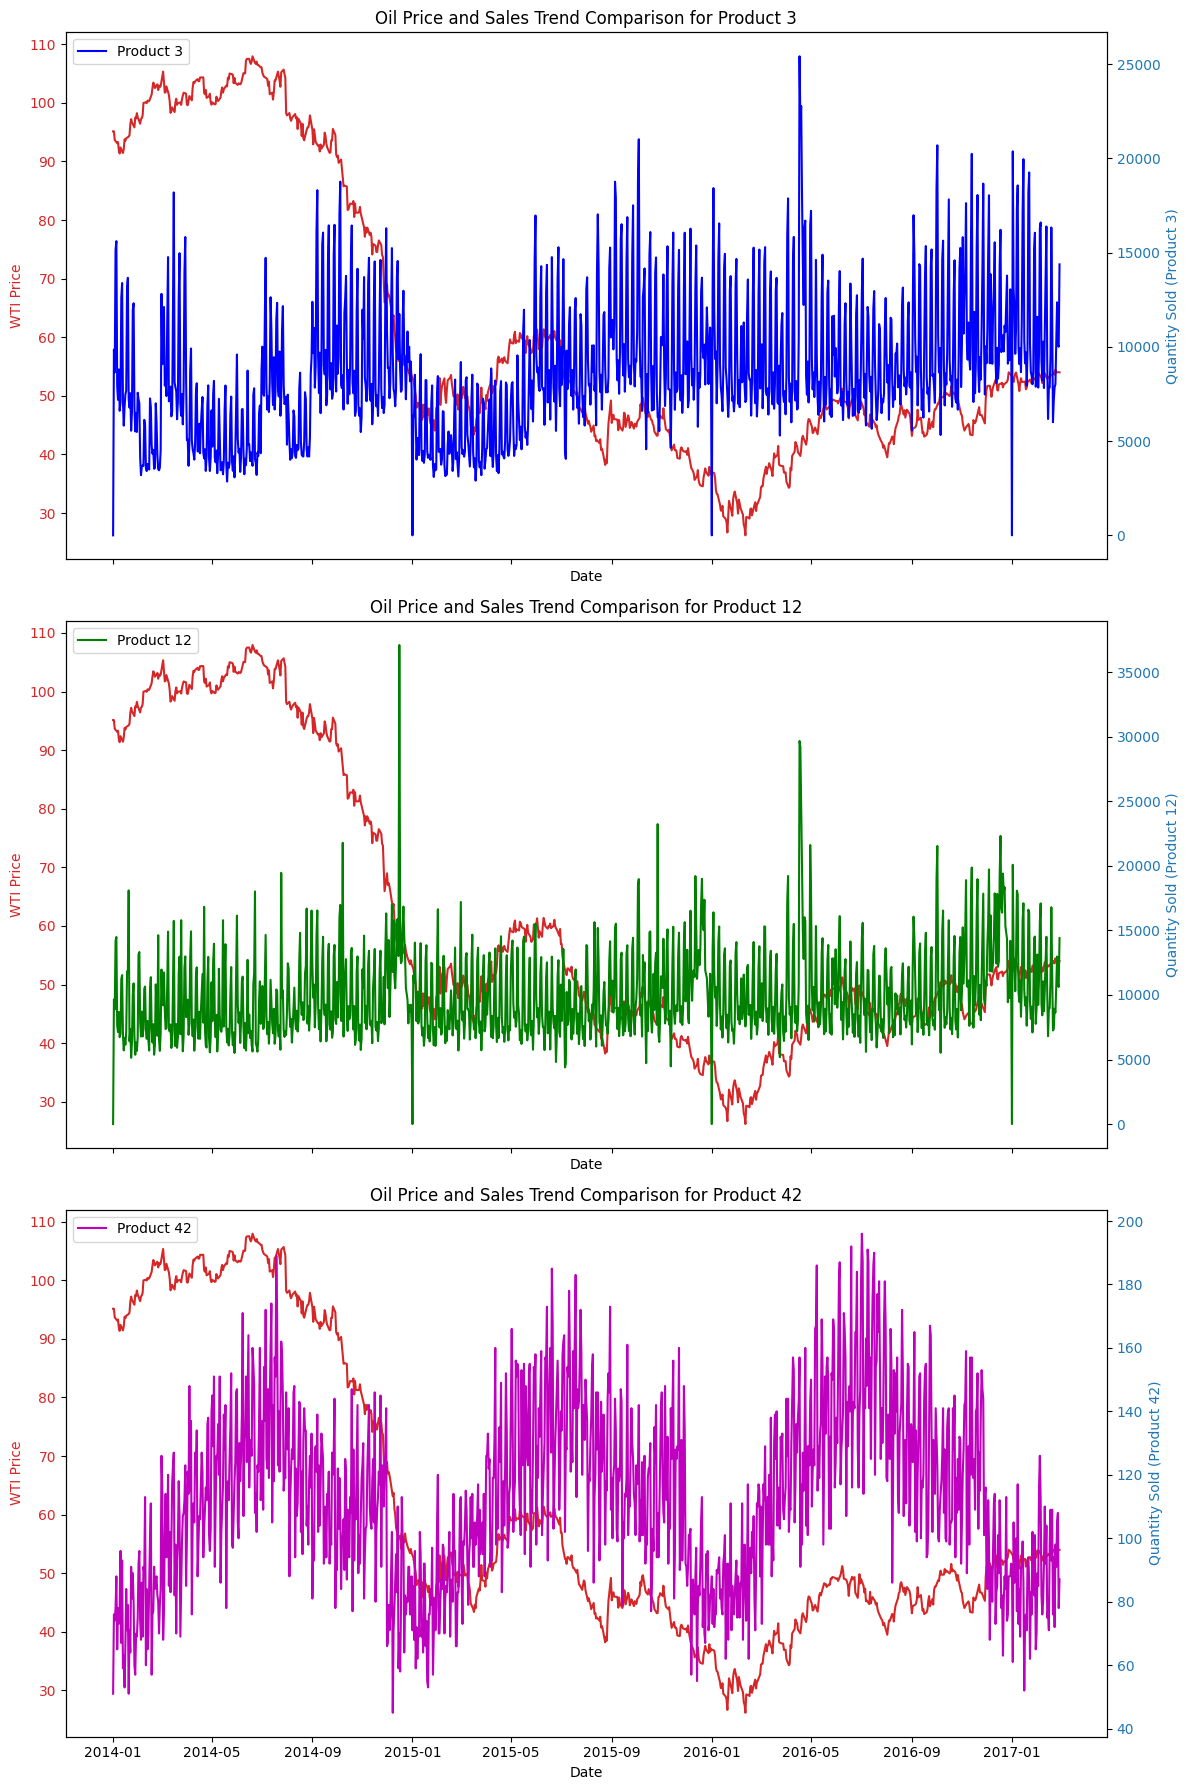

In [26]:
import numpy as np
colors = ['b', 'g', 'm']
fig, axes = plt.subplots(3, 1, figsize=(12, 18), sharex=True)

for i, ax in enumerate(axes):
    color = 'tab:red'
    ax.set_xlabel('Date')
    ax.set_ylabel('WTI Price', color=color)
    ax.plot(oil_price2['Date'], oil_price2['WTI_Price'], color=color)
    ax.tick_params(axis='y', labelcolor=color)

    product = target_products[i]
    product_sales = merged_df[(merged_df['Store_ID'] == target_store) & (merged_df['Product_ID'] == product)]

    ax2 = ax.twinx()
    color = 'tab:blue'
    ax2.set_ylabel(f'Quantity Sold (Product {product})', color=color)
    ax2.plot(product_sales['Date'], product_sales['Qty'], label=f'Product {product}', color=colors[i], linestyle='-')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.legend(loc='upper left')

    ax.set_title(f'Oil Price and Sales Trend Comparison for Product {product}')

fig.tight_layout()
plt.show()

In [27]:
#product 3, 12는 유가와 상관관계가 적으나, 42는 유가와 어느정도 비슷한 추세를 따른다

### 4) 방문 고객수와 상품 판매량 추이 비교

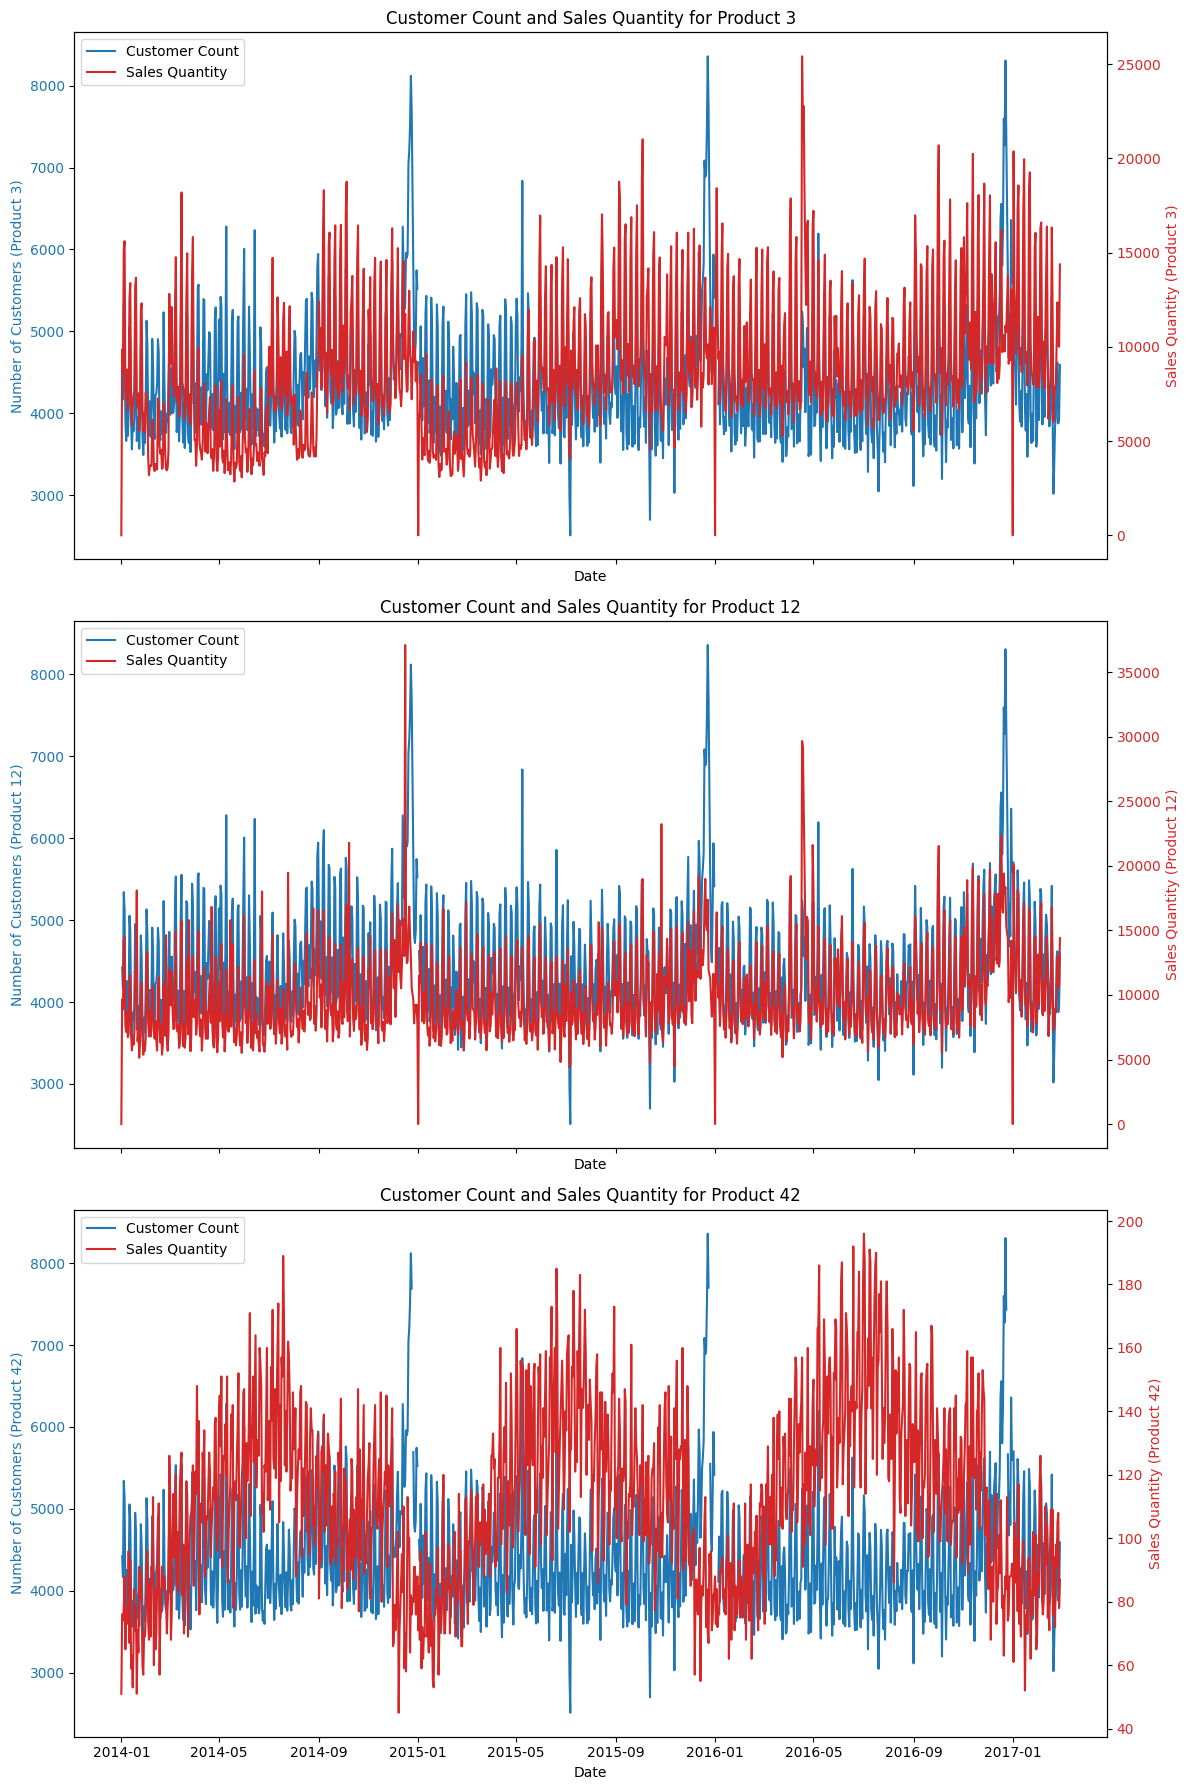

In [28]:
import numpy as np
colors = ['b', 'g', 'm']
fig, axes = plt.subplots(3, 1, figsize=(12, 18), sharex=True)

for i, ax in enumerate(axes):
    ax.set_xlabel('Date')

    product = target_products[i]
    product_data = merged_df[(merged_df['Store_ID'] == target_store) & (merged_df['Product_ID'] == product)]

    color = 'tab:blue'
    ax.set_ylabel(f'Number of Customers (Product {product})', color=color)
    ax.plot(product_data['Date'], product_data['CustomerCount'], color=color, linestyle='-', label='Customer Count')
    ax.tick_params(axis='y', labelcolor=color)

    ax2 = ax.twinx()
    color = 'tab:red'
    ax2.set_ylabel(f'Sales Quantity (Product {product})', color=color)
    ax2.plot(product_data['Date'], product_data['Qty'], color=color, linestyle='-', label='Sales Quantity')
    ax2.tick_params(axis='y', labelcolor=color)

    lines = ax.get_lines() + ax2.get_lines()
    ax.legend(lines, [line.get_label() for line in lines], loc='upper left')

    ax.set_title(f'Customer Count and Sales Quantity for Product {product}')

fig.tight_layout()
plt.show()

In [29]:
#product12(우유)가 방문자수와 가장 큰 상관관계를 보이고, product42는 비교적 방문자수와 상관관계가 적다

## **(2) 시계열 패턴 찾아보기2**

* 변화량과 비교해보기

### 1) 대상 매장(44), 대상 상품의 판매량 추이

### 2) 요일별 변화량 비교

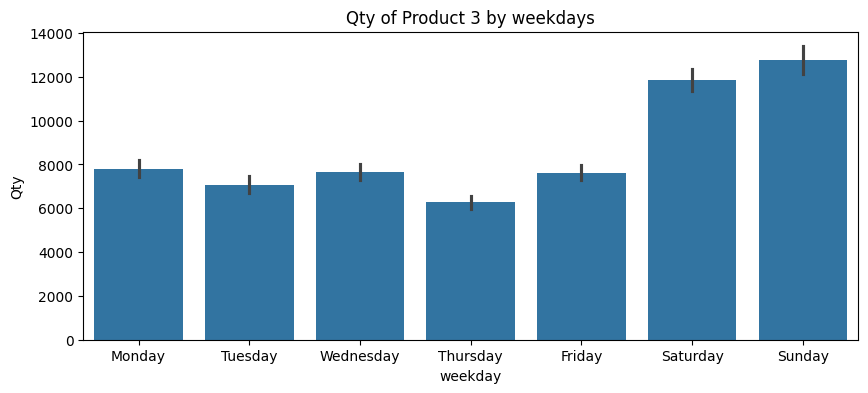

In [30]:
df1 = pd.merge(sales, products, on='Product_ID')
df2 = pd.merge(df1, stores, on='Store_ID')
df2 = df2[df2['Store_ID'] == 44]
df42 = df2[df2['Product_ID'] == 3]

# 요일 순서 정의
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']

# 요일 컬럼을 Categorical 타입으로 변환하고 범주 순서 설정
df42['weekday'] = pd.Categorical(df42['Date'].dt.day_name(), categories=day_order, ordered=True)
df42['weekday'] = df42['weekday'].cat.codes

plt.figure(figsize=(10, 4))
plt.title('Qty of Product 3 by weekdays')
sns.barplot(x='weekday', y='Qty', data=df42, order=range(7))
plt.xticks(range(7), day_order)
plt.show()

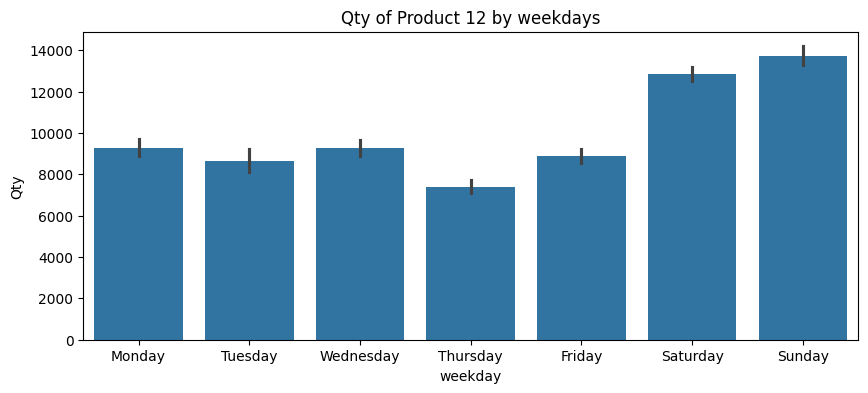

In [31]:
df1 = pd.merge(sales, products, on='Product_ID')
df2 = pd.merge(df1, stores, on='Store_ID')
df2 = df2[df2['Store_ID'] == 44]
df42 = df2[df2['Product_ID'] == 12]

# 요일 순서 정의
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']

# 요일 컬럼을 Categorical 타입으로 변환하고 범주 순서 설정
df42['weekday'] = pd.Categorical(df42['Date'].dt.day_name(), categories=day_order, ordered=True)
df42['weekday'] = df42['weekday'].cat.codes

plt.figure(figsize=(10, 4))
plt.title('Qty of Product 12 by weekdays')
sns.barplot(x='weekday', y='Qty', data=df42, order=range(7))
plt.xticks(range(7), day_order)
plt.show()

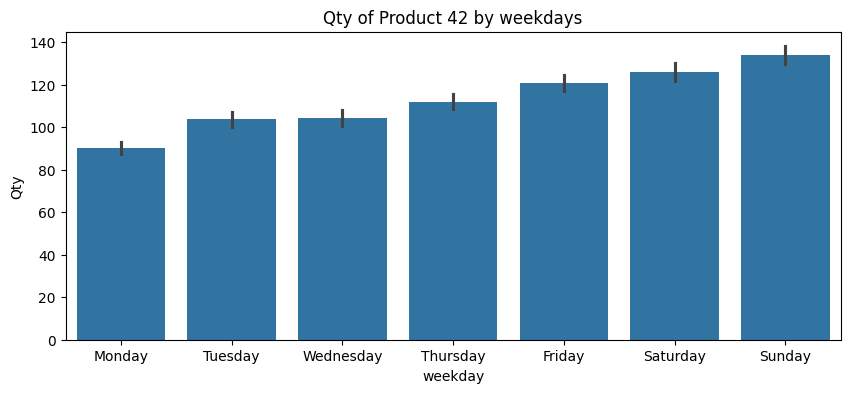

In [32]:
df1 = pd.merge(sales, products, on='Product_ID')
df2 = pd.merge(df1, stores, on='Store_ID')
df2 = df2[df2['Store_ID'] == 44]
df42 = df2[df2['Product_ID'] == 42]

# 요일 순서 정의
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']

# 요일 컬럼을 Categorical 타입으로 변환하고 범주 순서 설정
df42['weekday'] = pd.Categorical(df42['Date'].dt.day_name(), categories=day_order, ordered=True)
df42['weekday'] = df42['weekday'].cat.codes

plt.figure(figsize=(10, 4))
plt.title('Qty of Product 42 by weekdays')
sns.barplot(x='weekday', y='Qty', data=df42, order=range(7))
plt.xticks(range(7), day_order)
plt.show()

### 2-1) 공휴일별 변화량 비교

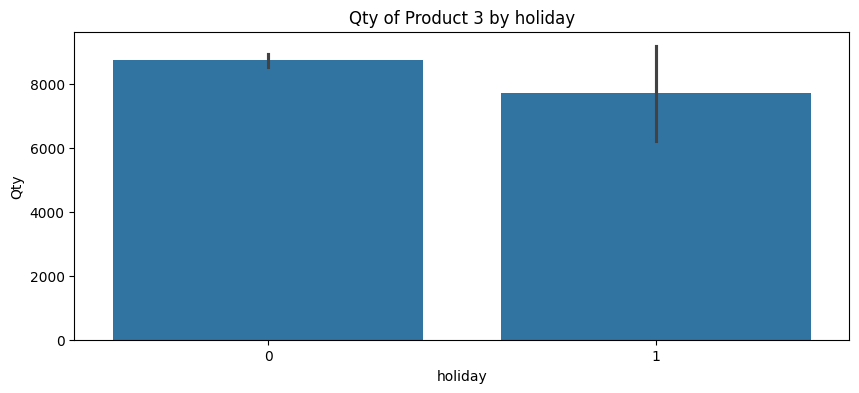

In [36]:
import holidays
import pandas as pd

df1 = pd.merge(sales, products, on='Product_ID')
df2 = pd.merge(df1, stores, on='Store_ID')
df2 = df2[df2['Store_ID'] == 44]
df42 = df2[df2['Product_ID'] == 3]

usa_holidays = holidays.USA()
df42['holiday'] = df42['Date'].apply(lambda x: 1 if x in usa_holidays else 0 )

plt.figure(figsize=(10, 4))
plt.title('Qty of Product 3 by holiday')
sns.barplot(x='holiday', y='Qty', data=df42)
plt.show()

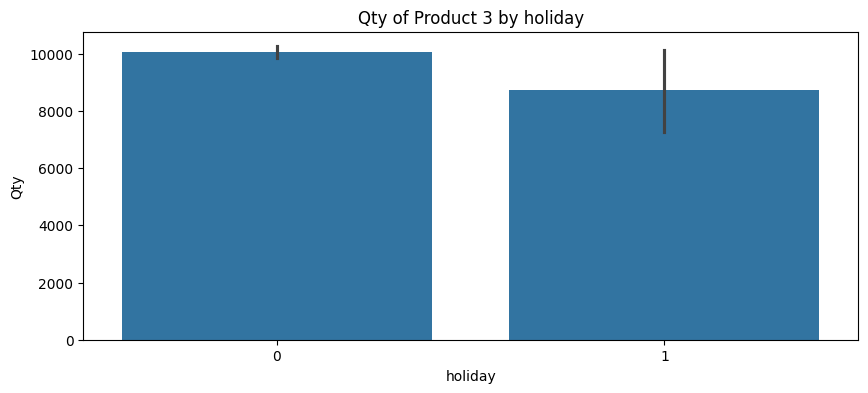

In [37]:
import holidays
import pandas as pd

df1 = pd.merge(sales, products, on='Product_ID')
df2 = pd.merge(df1, stores, on='Store_ID')
df2 = df2[df2['Store_ID'] == 44]
df42 = df2[df2['Product_ID'] == 12]

usa_holidays = holidays.USA()
df42['holiday'] = df42['Date'].apply(lambda x: 1 if x in usa_holidays else 0 )

plt.figure(figsize=(10, 4))
plt.title('Qty of Product 3 by holiday')
sns.barplot(x='holiday', y='Qty', data=df42)
plt.show()

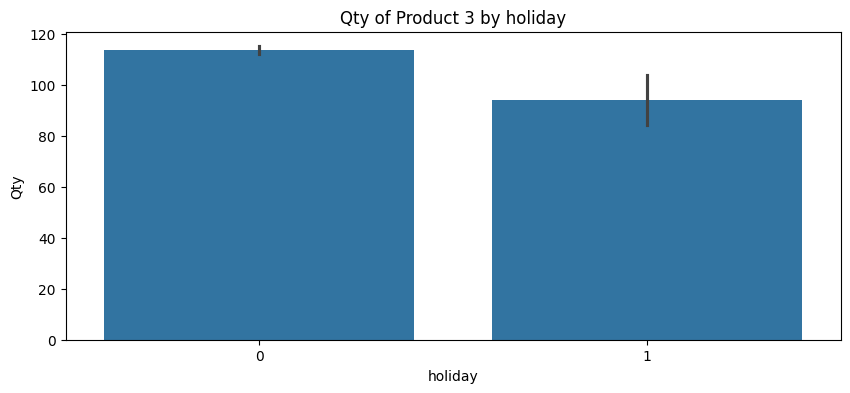

In [38]:
import holidays
import pandas as pd

df1 = pd.merge(sales, products, on='Product_ID')
df2 = pd.merge(df1, stores, on='Store_ID')
df2 = df2[df2['Store_ID'] == 44]
df42 = df2[df2['Product_ID'] == 42]

usa_holidays = holidays.USA()
df42['holiday'] = df42['Date'].apply(lambda x: 1 if x in usa_holidays else 0 )

plt.figure(figsize=(10, 4))
plt.title('Qty of Product 3 by holiday')
sns.barplot(x='holiday', y='Qty', data=df42)
plt.show()

<Figure size 2000x800 with 0 Axes>

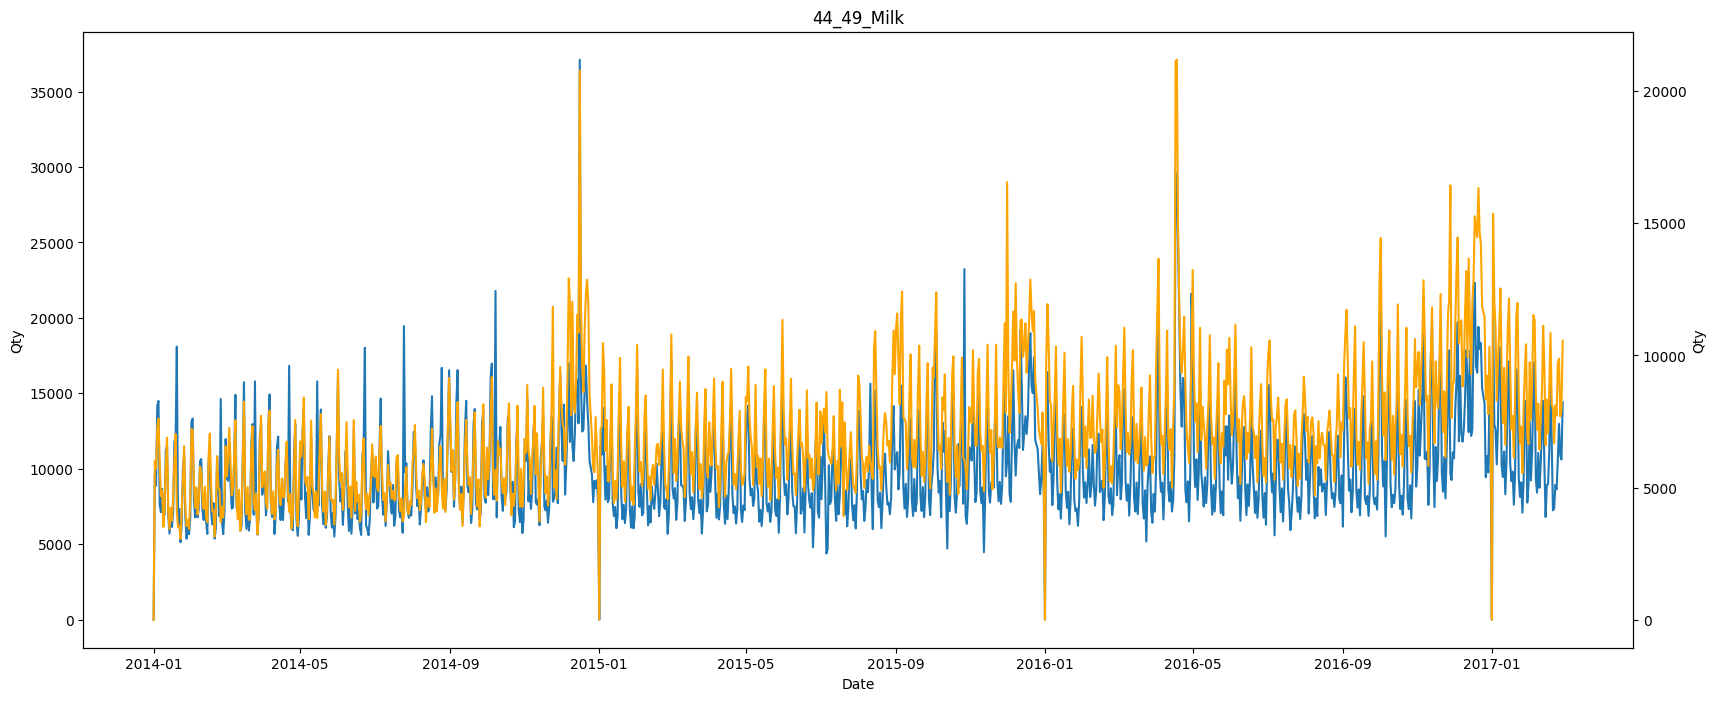

In [39]:
plt.figure(figsize=(20,8))


sales_of_i = sales.loc[sales['Store_ID']==44]
sale_product_i = pd.merge(sales_of_i,products, on='Product_ID')
product_12 = sale_product_i.loc[sale_product_i['Product_ID']==12] # 우유


sales_of_i = sales.loc[sales['Store_ID']==49]
sale_product_i = pd.merge(sales_of_i,products, on='Product_ID')
Milk_i = sale_product_i.loc[sale_product_i['Product_ID']==12] # 우유

plt.figure(figsize=(20,8))
ax = sns.lineplot(product_12, x='Date',y='Qty')
ax2 = ax.twinx()
ax2 = sns.lineplot(Milk_i, x='Date',y='Qty',color='orange')

plt.title("44_49_Milk")
plt.show()

### 3) 시계열 데이터 분해

In [ ]:
def decomp_plot(Product_ID, sdate, edate, period ) :

    # 시계열 데이터 분해
    temp = sales.loc[(sales['Store_ID'] == 44) & (sales['Product_ID'] == Product_ID) & (sales['Date'].between(sdate, edate))]
    decomp = sm.tsa.seasonal_decompose(temp['Qty'], model = 'additive', period = period)

    # 시계열 분해 결과를 받아서 데이터프레임으로 저장
    result = pd.DataFrame({'observed':decomp.observed, 'trend':decomp.trend, 'seasonal':decomp.seasonal, 'residual':decomp.resid})

    # 4개의 그래프로 나눠서 그리기
    plt.figure(figsize=(15, 8))

    plt.subplot(4,1,1)
    plt.plot(result['observed'])
    plt.ylabel('observed')

    plt.subplot(4,1,2)
    plt.plot(result['trend'])
    plt.ylabel('trend')

    plt.subplot(4,1,3)
    plt.plot(result['seasonal'])
    plt.ylabel('seasonal')

    plt.subplot(4,1,4)
    plt.plot(result['residual'])
    plt.ylabel('residual')
    plt.show()

    return result

### 4) 그 외 패턴 찾아보기

# **3.패턴 정리하기**

* 다양한 탐색을 통해 찾은 시계열 패턴을 적어 봅시다.